# Passengers Denied Confirmed Space

In [1]:
library(data.table)
library(dplyr)
library(tidyr)
library(ggplot2)

options(jupyter.plot_mimetypes = "image/png") 
options(repr.plot.width = 16/2, repr.plot.height = 9/2)

------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Getting the Data

Source: https://www.rita.dot.gov/bts/sites/rita.dot.gov.bts/files/subject_areas/airline_information/passengers_denied_confirmed_space_report/2016/index.html

### The Data Set

*Column 1:* Number of passengers who were denied boarding involuntarily who qualified for denied boarding  compensation and:

- *Column 1(a):* were given alternate transportation within the meaning of section 250.5 
- *Column 1(b):* were not given such alternate transportation 

*Column 2:* Number of passengers denied boarding involuntarily who did not qualify for denied boarding compensation

*Column 3:* Total number denied boarding involuntarily

*Column 4:* Number of passengers denied boarding involuntarily who actually received compensation

*Column 5:* Number of passengers who volunteered to give up reserved space in exchange for a payment of the carrier's choosing

*Column 6:* Number of Passengers accommodated in another section of the aircraft

*Column 7:* Total Boardings

*Column 8:* Amount of Compensation paid to passenger who:

- *Column 8(a):* were denied boarding involuntarily and were given alternate transportation within the meaning of section 250.5
- *Column 8(b):* were denied boarding involuntarily and were not given alternate transportation
- *Column 8(c):* volunteered for denied boarding

In [2]:
base_url <- "https://www.rita.dot.gov/bts/sites/rita.dot.gov.bts/files/"
datasets <- c("2014_1q", "2014_2q", "2014_3q", "2014_4q", 
              "2015_1q", "2015_2q", "2015_3q", "2015_4q", 
              "2016_1q", "2016_4q_0")

# The data for 2016-Q2 and 2016-Q3 aren't available in CSV format, 
# and somehow the file for 4q is suffixed with '_0'. 
data <- do.call(rbind, lapply(
  datasets, 
  function(q) {
    raw <- fread(paste(base_url, q, ".csv", sep=""), header=FALSE)
    raw <- raw[, 1:15]

    print(paste("Processing:", raw[2, 1]))
    header <- as.character(raw[raw$V1 == "CARRIER", ])
    raw <- raw[(raw$V2 != "") & (raw$V1 != "CARRIER"), ]  # Exclude metatdata/header rows 
    colnames(raw) <- header 

    data_by_quarter <- cbind(
      raw[, 1],  # Carrier name
      sapply(raw[, -1], function(col) { as.numeric(gsub("[,|$]", "", col)) } ),  # Remove , and $ and convert to numeric
      quarter = paste(substring(q, 1, 4), paste("Q", substring(q, 6, 6), sep=""))  # Specify quarter
    )

    return(data_by_quarter)
  }
))

[1] "Processing: Quarter Ended 3/31/2014"
[1] "Processing: Quarter Ended 6/30/2014"
[1] "Processing: Quarter Ended 9/30/2014"
[1] "Processing: Quarter Ended 12/31/2014"
[1] "Processing: Quarter Ended 3/31/2015"
[1] "Processing: Quarter Ended 6/30/2015"
[1] "Processing: Quarter Ended 9/30/2015"
[1] "Processing: Quarter Ended 12/31/2015"
[1] "Processing: Quarter Ended 3/31/2016"
[1] "Processing: Quarter Ended 12/31/2016"


In [3]:
head(data)

CARRIER,1(a),1(b),2(a),2(b),2(c),3,4,5,6(a),6(b),7,8(a),8(b),8(c),quarter
AirTran Airways,0,834,0,0,7,841,834,10336,0,0,4525112,487449,0,0,2014 Q1
Alaska Airlines,0,124,0,15,51,190,124,1155,11,21,4203186,0,131215,0,2014 Q1
American Airlines,126,678,0,182,39,1025,986,12822,1078,223,18267561,49157,638099,0,2014 Q1
American Eagle,35,227,0,264,17,543,526,5320,73,10,3971731,8304,191631,0,2014 Q1
Delta Air Lines,76,847,197,18,139,1277,923,22445,27969,11651,24130377,41526,987176,0,2014 Q1
ExpressJet,30,1616,63,22,32,1763,1610,13100,3999,2343,7107265,29071,1070441,32225,2014 Q1


In [4]:
# Remove airlines that aren't in all datasets
print("Before: ")
unique(data$CARRIER)

data <- data %>%
  group_by(CARRIER) %>% 
  filter(n() == length(datasets)) %>%
  ungroup()

print("After: ")
unique(data$CARRIER)

[1] "Before: "


[1] "AirTran Airways"    "Alaska Airlines"    "American Airlines" 
 [4] "American Eagle"     "Delta Air Lines"    "ExpressJet"        
 [7] "Frontier Airlines"  "Hawaiian Airlines"  "JetBlue Airways"   
[10] "SkyWest Airlines"   "Southwest Airlines" "United Air Lines"  
[13] "US Airways"         "Virgin America"     "Envoy Airlines"    
[16] "Spirit Airlines"

[1] "After: "


[1] "Alaska Airlines"    "American Airlines"  "Delta Air Lines"   
 [4] "ExpressJet"         "Frontier Airlines"  "Hawaiian Airlines" 
 [7] "JetBlue Airways"    "SkyWest Airlines"   "Southwest Airlines"
[10] "United Air Lines"   "Virgin America"

In [5]:
# Stats
reaccommodated <- data %>%
  bind_rows(data %>%
    group_by(CARRIER) %>%
    select(-quarter) %>%
    summarise_each(funs(sum)) %>%
    mutate(quarter = "overall")
  ) %>%
  mutate(
    CARRIER = factor(CARRIER),
    quarter = factor(quarter),
    voluntary = `5`,
    involuntary = `3`,
    reaccommodated = `3` + `5`,
    boarded = `7`,
    rate = reaccommodated / boarded * 10000, 
    rate_voluntary = voluntary / boarded * 10000,
    rate_involuntary = involuntary / boarded * 10000,
    avg_comp = (`8(a)` + `8(b)` + `8(c)`) / reaccommodated
  )

# Rank by 2016 Q4 stats
rank_2016q4 <- reaccommodated %>%
  filter(quarter == '2016 Q4') %>%
  mutate(rank = min_rank(-rate)) %>%
  .$rank
reaccommodated$CARRIER <- factor(reaccommodated$CARRIER, levels = reaccommodated$CARRIER[order(-rank_2016q4)])

## How often are passengers denied boarding?

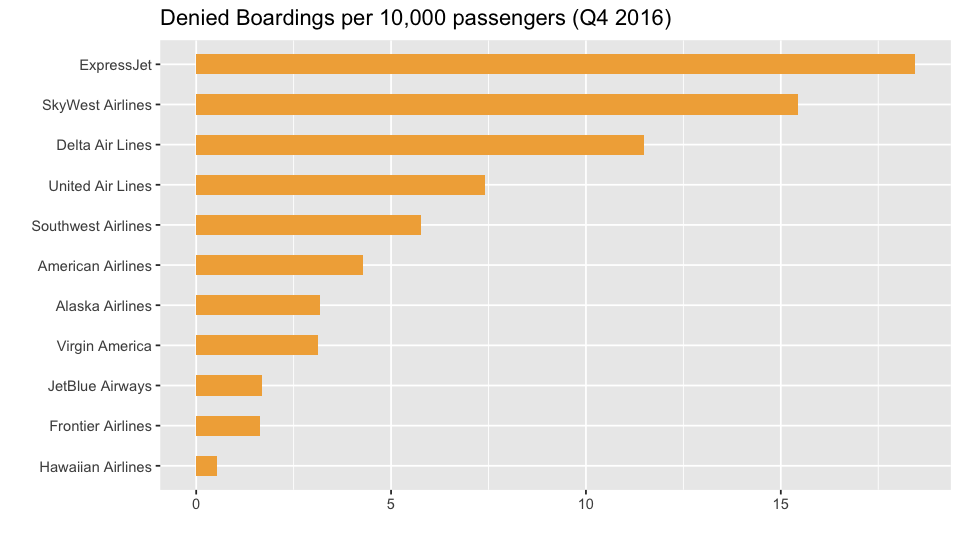

In [6]:
ggplot(reaccommodated %>% filter(quarter == '2016 Q4'), aes(x = CARRIER, y = rate)) +
  geom_bar(stat = "identity", width = 0.5, fill = "#f1ad46") +
  coord_flip() + 
  labs(x = "", y = "", title = "Denied Boardings per 10,000 passengers (Q4 2016)") 

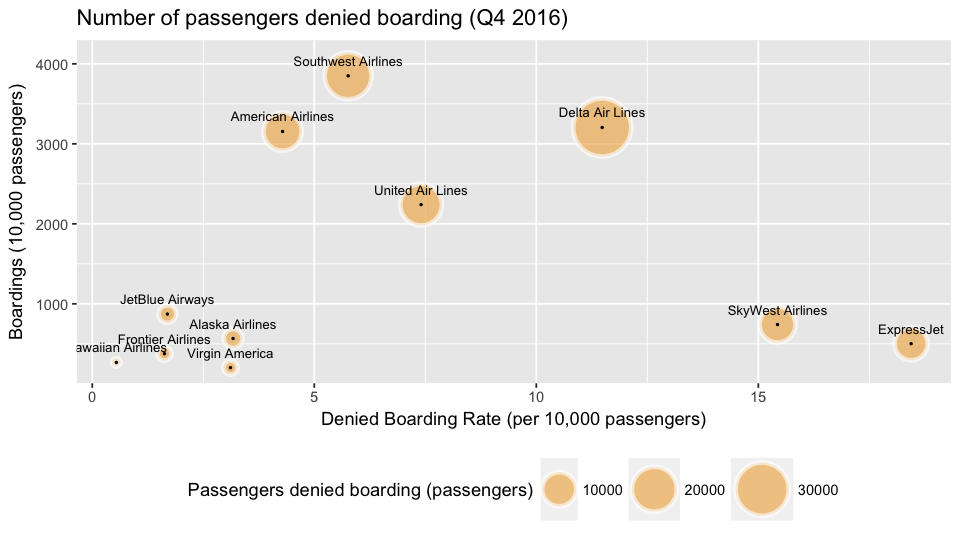

In [7]:
ggplot(reaccommodated %>% filter(quarter == '2016 Q4'), aes(size = reaccommodated, y = boarded / 10000, x = rate, label = CARRIER)) +
  geom_point(fill = "#f1ad46", alpha = .6, colour = "white", shape = 21, stroke = 2) +
  geom_point(color = "black", size = .3) +
  geom_text(aes(y = boarded / 10000 + 250), size = 2.8, hjust = 0.5, vjust = 1) +
  scale_size_continuous(range=c(1,15)) +
  labs(x = "Denied Boarding Rate (per 10,000 passengers)", 
       y = "Boardings (10,000 passengers)", 
       size = "Passengers denied boarding (passengers)", 
       title = "Number of passengers denied boarding (Q4 2016)") +
  theme(legend.position = "bottom")

In [8]:
reaccommodated %>% filter(quarter == '2016 Q4') %>% arrange(reaccommodated)


CARRIER,1(a),1(b),2(a),2(b),2(c),3,4,5,6(a),⋯,8(c),quarter,voluntary,involuntary,reaccommodated,boarded,rate,rate_voluntary,rate_involuntary,avg_comp
Hawaiian Airlines,19,0,0,0,0,19,0,126,0,⋯,12185,2016 Q4,126,19,145,2669657,0.5431409,0.4719707,0.07117019,159.179310
Frontier Airlines,2,110,0,36,15,163,59,450,0,⋯,1892,2016 Q4,450,163,613,3771280,1.6254428,1.1932288,0.43221400,80.686786
Virgin America,15,0,1,0,1,17,16,611,29,⋯,271828,2016 Q4,611,17,628,2017391,3.1129315,3.0286643,0.08426725,457.049363
JetBlue Airways,0,8,0,1028,0,1036,8,439,0,⋯,197966,2016 Q4,439,1036,1475,8719175,1.6916738,0.5034880,1.18818581,141.637966
Alaska Airlines,0,102,0,16,79,197,102,1600,37,⋯,0,2016 Q4,1600,197,1797,5665703,3.1717158,2.8240097,0.34770619,112.454090
ExpressJet,34,554,12,36,5,641,622,8615,3313,⋯,1350,2016 Q4,8615,641,9256,5019172,18.4412887,17.1641856,1.27710308,50.611387
SkyWest Airlines,43,540,37,126,12,758,709,10680,5513,⋯,0,2016 Q4,10680,758,11438,7411535,15.4327005,14.4099704,1.02273011,32.455150
American Airlines,111,854,0,727,22,1714,1692,11806,299,⋯,0,2016 Q4,11806,1714,13520,31546560,4.2857288,3.7424049,0.54332390,83.192308
United Air Lines,22,545,19,296,9,891,866,15696,5463,⋯,0,2016 Q4,15696,891,16587,22398395,7.4054413,7.0076450,0.39779636,29.905348
Southwest Airlines,1511,462,0,0,1099,3072,1973,19116,0,⋯,0,2016 Q4,19116,3072,22188,38502306,5.7627717,4.9648974,0.79787429,76.972508


### The rankings haven't changed much over time.

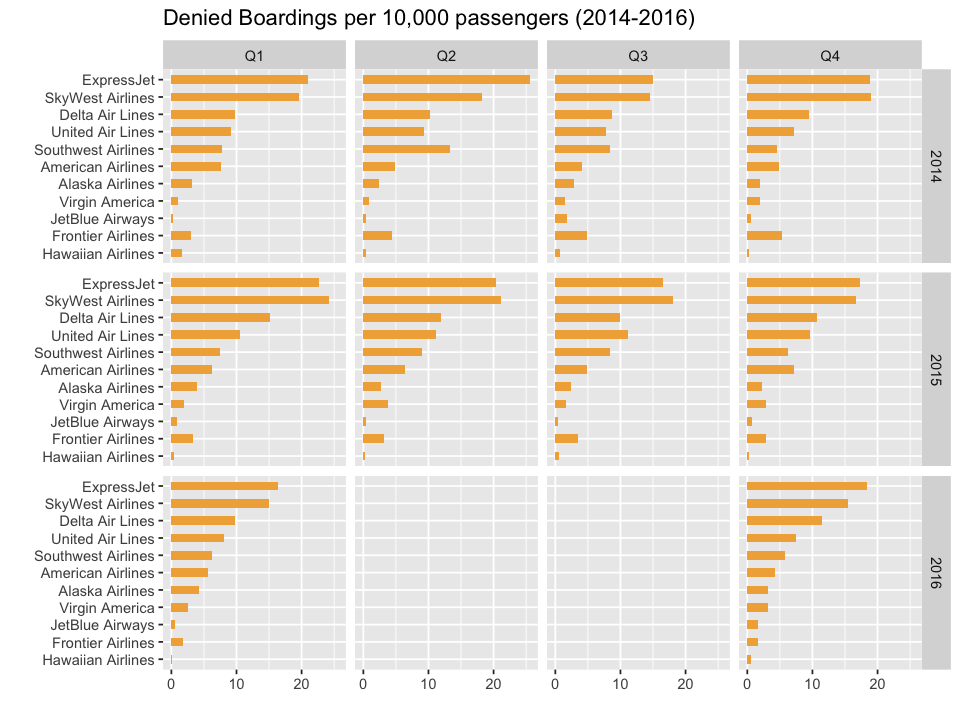

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6)

reaccommodated %>%
  filter(quarter != "overall") %>%
  mutate(
    year = substring(quarter, 1, 4),
    q = substring(quarter, 6, 7)
  ) %>%
  ggplot(aes(x = CARRIER, y = rate)) +
    geom_bar(stat = "identity", width = 0.5, fill = "#f1ad46") +
    facet_grid(year ~ q) +
    coord_flip() + 
    labs(x = "", y = "", title = "Denied Boardings per 10,000 passengers (2014-2016)")

options(repr.plot.width = 16/2, repr.plot.height = 9/2)

## Voluntarily vs. Involuntarily Denied Boardings

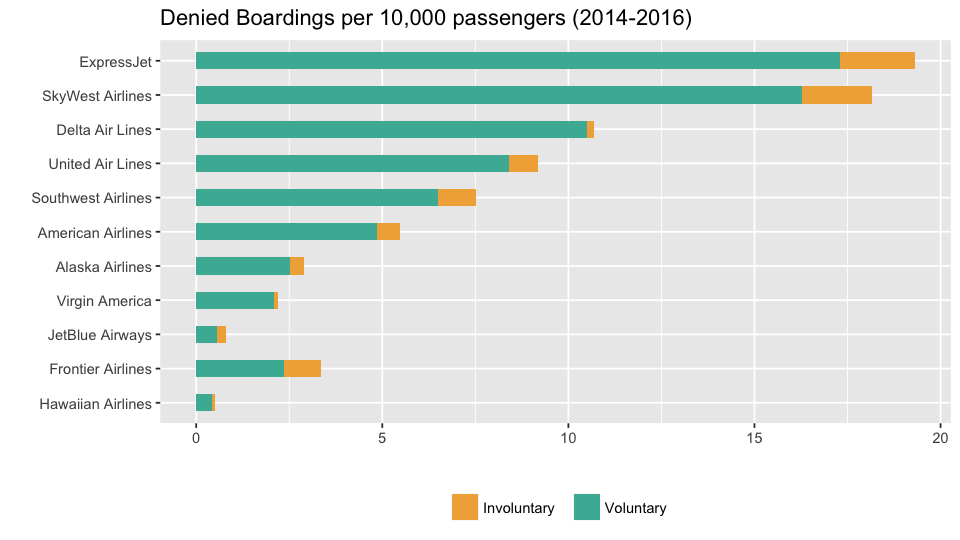

In [10]:
reaccommodated %>% 
  filter(quarter == "overall") %>%
  select(CARRIER, voluntary = rate_voluntary, involuntary = rate_involuntary) %>%
  gather("type", "rate", 2:3) %>%
  ggplot(aes(x = CARRIER, y = rate, fill = factor(type, levels=c("involuntary", "voluntary")))) +
    geom_bar(stat = "identity", width = 0.5) + 
    coord_flip() + 
    scale_fill_manual(values = c("#f1ad46", "#48B6A3"), labels = c("Involuntary   ", "Voluntary")) +
    labs(x = "", y = "", title = "Denied Boardings per 10,000 passengers (2014-2016)", fill = "") +
    theme(legend.position = "bottom")

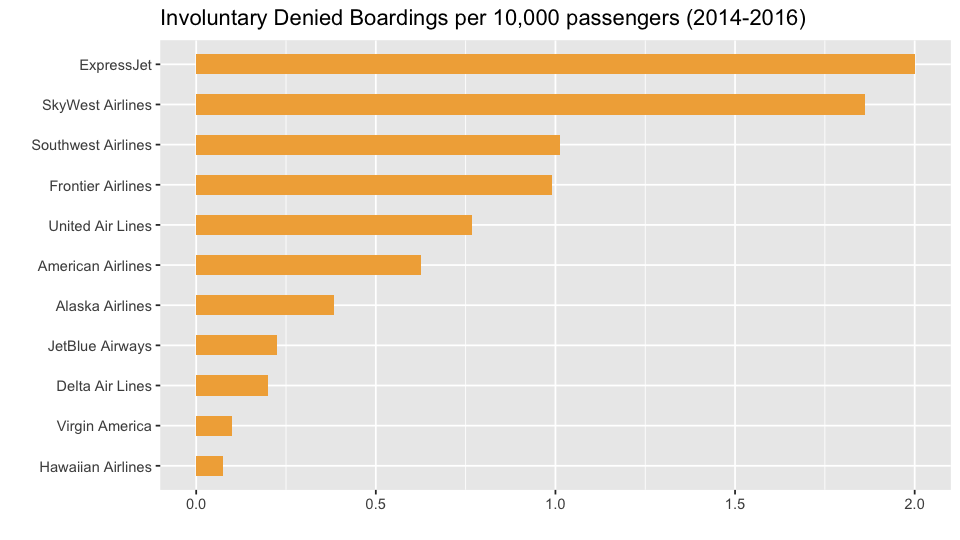

In [11]:
reaccommodated %>% 
  filter(quarter == "overall") %>%
  ggplot(aes(x = factor(CARRIER, levels=CARRIER[order(rate_involuntary)]), y = rate_involuntary)) +
    geom_bar(stat = "identity", width = 0.5, fill = "#f1ad46") + 
    coord_flip() + 
    labs(x = "", y = "", title = "Involuntary Denied Boardings per 10,000 passengers (2014-2016)")

## Compensation paid to passengers denied boarding 

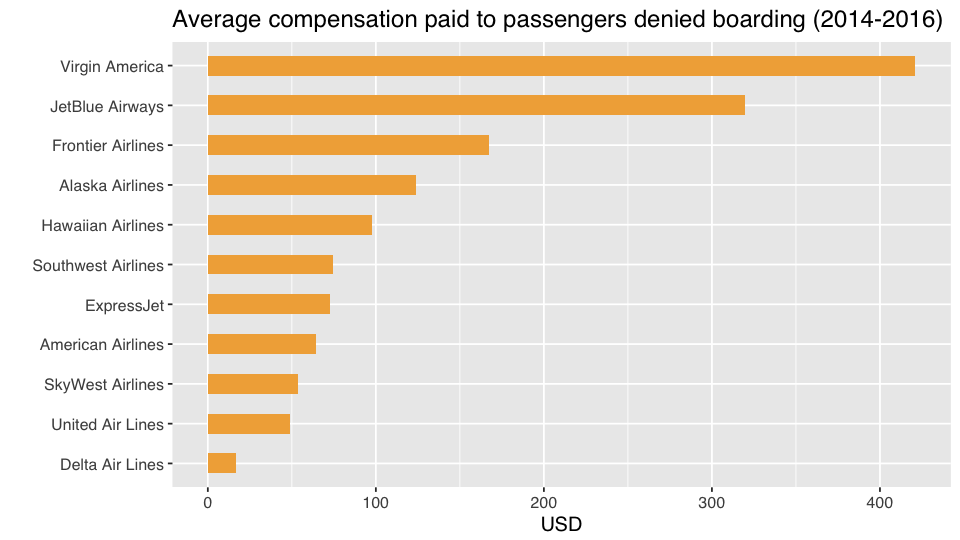

In [12]:
reaccommodated %>%
  filter(quarter == "overall") %>%
  ggplot(aes(x = factor(CARRIER, levels = CARRIER[order(avg_comp)]), y = avg_comp)) +
    geom_bar(stat = "identity", width = 0.5, fill = "#f1ad46") + 
    coord_flip() + 
    labs(x = "", y = "USD", title = "Average compensation paid to passengers denied boarding (2014-2016)") +
    theme(text = element_text(family = "Helvetica", size = 12))